1. Installing essential libraries like PyTorch, Transformers, TensorFlow Datasets, Matplotlib, and NumPy for model building, data handling, and visualization.

In [1]:
!pip install torch torchvision transformers tensorflow-datasets matplotlib numpy --quiet

2. Importing necessary libraries for deep learning, image processing, and text encoding, and set the device to GPU if available for faster computation.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from transformers import AutoTokenizer, AutoModel
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


3. Loading the Oxford Flowers 102 dataset using TensorFlow Datasets, apply transformations (resize, normalize), and wrap it in a custom PyTorch Dataset and DataLoader for efficient training.

In [3]:
dataset, info = tfds.load('oxford_flowers102', split='train+validation+test', with_info=True, as_supervised=True)
class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f"Dataset loaded: {info.name} with {num_classes} classes")

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((64,64)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

class FlowersDataset(torch.utils.data.Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.tf_dataset = list(tf_dataset)
        self.transform = transform

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        image, label = self.tf_dataset[idx]
        image = image.numpy()
        if self.transform:
            image = self.transform(image)
        label = int(label.numpy())
        return image, label

flowers_dataset = FlowersDataset(dataset, transform=transform)

batch_size = 32
dataloader = torch.utils.data.DataLoader(flowers_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Dataset loaded: oxford_flowers102 with 102 classes


4. Using a pre-trained DistilBERT model to generate text embeddings for flower class descriptions using mean pooling over the token embeddings.

In [4]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)
bert_model.eval()

descriptions = [f"A photo of a {name} flower." for name in class_names]

encoded = tokenizer(descriptions, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = bert_model(**encoded)
    last_hidden_states = outputs.last_hidden_state

def mean_pooling(hidden_states, attention_mask):
    mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
    sum_embeddings = torch.sum(hidden_states * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

text_embeddings = mean_pooling(last_hidden_states, encoded['attention_mask'])  
print(f"Text embeddings shape: {text_embeddings.shape}") 

Text embeddings shape: torch.Size([102, 768])


5. Defining Self-Attention and Cross-Attention modules to enhance feature learning in the GAN.

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(dim, dim // 8, 1)
        self.key = nn.Conv2d(dim, dim // 8, 1)
        self.value = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query(x).view(B, -1, W*H).permute(0,2,1)
        proj_key = self.key(x).view(B, -1, W*H)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value(x).view(B, C, W*H)

        out = torch.bmm(proj_value, attention.permute(0,2,1))
        out = out.view(B, C, W, H)

        out = self.gamma * out + x
        return out

class CrossAttention(nn.Module):
    def __init__(self, image_dim, text_dim, out_dim):
        super(CrossAttention, self).__init__()
        self.query_conv = nn.Conv2d(image_dim, image_dim // 8, 1)
        self.key_fc = nn.Linear(text_dim, image_dim // 8)
        self.value_fc = nn.Linear(text_dim, out_dim)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, image_feat, text_emb):
        
        B, C, W, H = image_feat.size()
        proj_query = self.query_conv(image_feat).view(B, -1, W*H).permute(0,2,1)  

        proj_key = self.key_fc(text_emb).unsqueeze(-1)  
        proj_key = proj_key.expand(-1, -1, W*H)         

        energy = torch.bmm(proj_query, proj_key)        
        attention = self.softmax(energy)

        proj_value = self.value_fc(text_emb).unsqueeze(-1)  
        proj_value = proj_value.expand(-1, -1, W*H)        

        out = torch.bmm(proj_value, attention.permute(0,2,1)) 
        out = out.view(B, -1, W, H)

        out = self.gamma * out + image_feat
        return out

6. Define the Generator that uses noise and text embeddings with self- and cross-attention to generate realistic flower images.

In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, text_emb_dim=768, base_channels=64):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.text_emb_dim = text_emb_dim
        self.fc = nn.Linear(noise_dim + text_emb_dim, base_channels * 8 * 4 * 4)

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(True)
        )
        self.attn1 = SelfAttention(base_channels * 4)

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(True)
        )
        self.cross_attn = CrossAttention(base_channels * 2, text_emb_dim, base_channels * 2)

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(True)
        )

        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(base_channels, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise, text_emb):
        x = torch.cat([noise, text_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)

        x = self.upconv1(x)
        x = self.attn1(x)

        x = self.upconv2(x)
        x = self.cross_attn(x, text_emb)

        x = self.upconv3(x)
        x = self.upconv4(x)
        return x

7. Define the Discriminator that uses self- and cross-attention to evaluate if an image matches the given text, helping the model distinguish real from fake images.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, text_emb_dim=768, base_channels=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, base_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.self_attn = SelfAttention(base_channels * 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.cross_attn = CrossAttention(base_channels * 4, text_emb_dim, base_channels * 4)

        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 8, 4, 2, 1),
            nn.BatchNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.final_conv = nn.Conv2d(base_channels * 8, 1, 4, 1, 0)

        self.text_emb_proj = nn.Linear(text_emb_dim, base_channels * 8)

    def forward(self, img, text_emb):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.self_attn(x)
        x = self.conv3(x)
        x = self.cross_attn(x, text_emb)
        x = self.conv4(x)

        text_proj = self.text_emb_proj(text_emb).unsqueeze(2).unsqueeze(3)
        x = x + text_proj

        x = self.final_conv(x)
        x = torch.sigmoid(x)
        return x.view(-1)

8. Setting up Generator, Discriminator, optimizers, loss, and fixed inputs for training.

In [8]:
noise_dim = 100
text_emb_dim = 768

G = Generator(noise_dim, text_emb_dim).to(device)
D = Discriminator(text_emb_dim).to(device)

criterion = nn.BCELoss()
lr = 2e-4
beta1 = 0.5

optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, noise_dim, device=device)
fixed_text = text_embeddings[:batch_size].to(device)  

9. Training GAN for 100 epochs and show sample images every 10 epochs.

Starting Training...
Epoch [1/100] D Loss: 0.6951 G Loss: 8.5195
Epoch [2/100] D Loss: 0.4884 G Loss: 6.9223
Epoch [3/100] D Loss: 0.3865 G Loss: 5.7451
Epoch [4/100] D Loss: 0.8431 G Loss: 3.6232
Epoch [5/100] D Loss: 0.8082 G Loss: 3.8699
Epoch [6/100] D Loss: 0.7193 G Loss: 3.7685
Epoch [7/100] D Loss: 0.7070 G Loss: 3.9431
Epoch [8/100] D Loss: 0.7183 G Loss: 3.9957
Epoch [9/100] D Loss: 0.5644 G Loss: 4.0293
Epoch [10/100] D Loss: 0.6723 G Loss: 4.1461


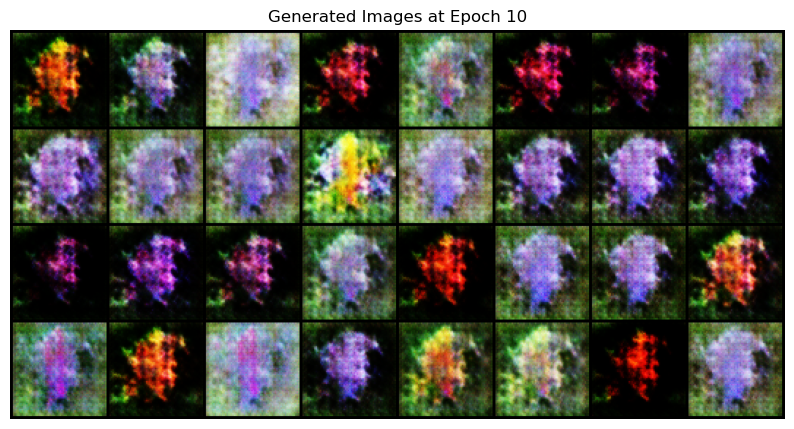

Epoch [11/100] D Loss: 0.5979 G Loss: 4.3182
Epoch [12/100] D Loss: 0.6664 G Loss: 4.1799
Epoch [13/100] D Loss: 0.5759 G Loss: 4.5271
Epoch [14/100] D Loss: 0.5984 G Loss: 4.5671
Epoch [15/100] D Loss: 0.6269 G Loss: 4.3092
Epoch [16/100] D Loss: 0.5924 G Loss: 4.7770
Epoch [17/100] D Loss: 0.6697 G Loss: 4.4194
Epoch [18/100] D Loss: 0.6430 G Loss: 4.1647
Epoch [19/100] D Loss: 0.7008 G Loss: 4.1949
Epoch [20/100] D Loss: 0.4469 G Loss: 4.9999


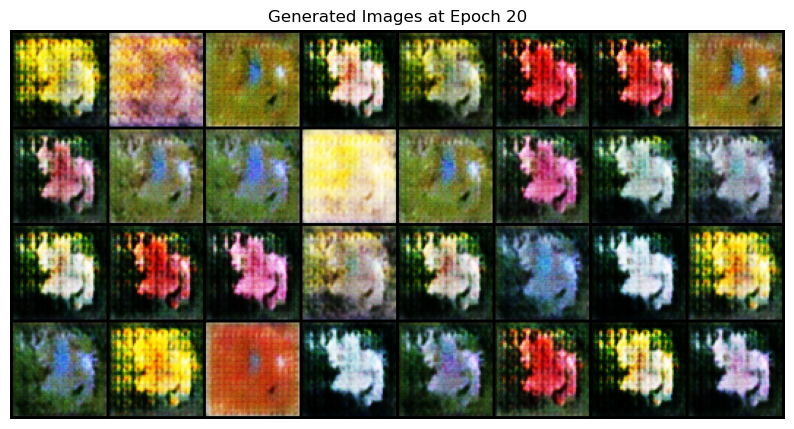

Epoch [21/100] D Loss: 0.4303 G Loss: 5.0949
Epoch [22/100] D Loss: 0.4208 G Loss: 5.1704
Epoch [23/100] D Loss: 0.4318 G Loss: 5.1701
Epoch [24/100] D Loss: 0.4182 G Loss: 5.6500
Epoch [25/100] D Loss: 0.3712 G Loss: 5.3737
Epoch [26/100] D Loss: 0.2850 G Loss: 5.9963
Epoch [27/100] D Loss: 0.3212 G Loss: 6.3524
Epoch [28/100] D Loss: 0.3072 G Loss: 5.9210
Epoch [29/100] D Loss: 0.3881 G Loss: 5.8957
Epoch [30/100] D Loss: 0.3236 G Loss: 5.6535


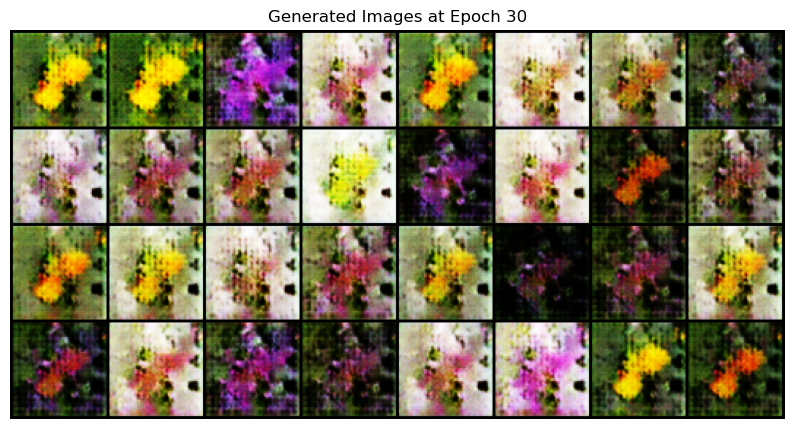

Epoch [31/100] D Loss: 0.2383 G Loss: 6.4459
Epoch [32/100] D Loss: 0.2871 G Loss: 5.9672
Epoch [33/100] D Loss: 0.3604 G Loss: 5.8378
Epoch [34/100] D Loss: 0.3582 G Loss: 5.8207
Epoch [35/100] D Loss: 0.3053 G Loss: 5.4289
Epoch [36/100] D Loss: 0.3114 G Loss: 5.7056
Epoch [37/100] D Loss: 0.3334 G Loss: 6.1714
Epoch [38/100] D Loss: 0.3741 G Loss: 6.1091
Epoch [39/100] D Loss: 0.3441 G Loss: 5.6947
Epoch [40/100] D Loss: 0.2847 G Loss: 5.5838


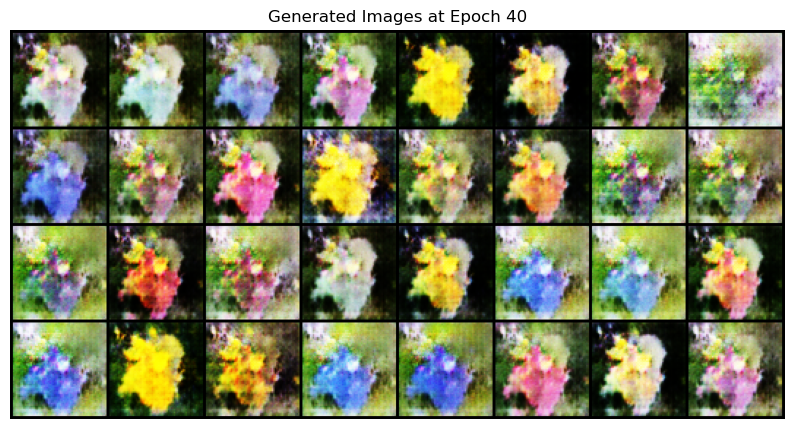

Epoch [41/100] D Loss: 0.3583 G Loss: 5.9767
Epoch [42/100] D Loss: 0.3107 G Loss: 5.6774
Epoch [43/100] D Loss: 0.3273 G Loss: 5.6045
Epoch [44/100] D Loss: 0.3769 G Loss: 5.7779
Epoch [45/100] D Loss: 0.4118 G Loss: 5.6137
Epoch [46/100] D Loss: 0.3551 G Loss: 5.3319
Epoch [47/100] D Loss: 0.3044 G Loss: 5.8161
Epoch [48/100] D Loss: 0.3861 G Loss: 5.2605
Epoch [49/100] D Loss: 0.3340 G Loss: 5.3168
Epoch [50/100] D Loss: 0.3949 G Loss: 5.3657


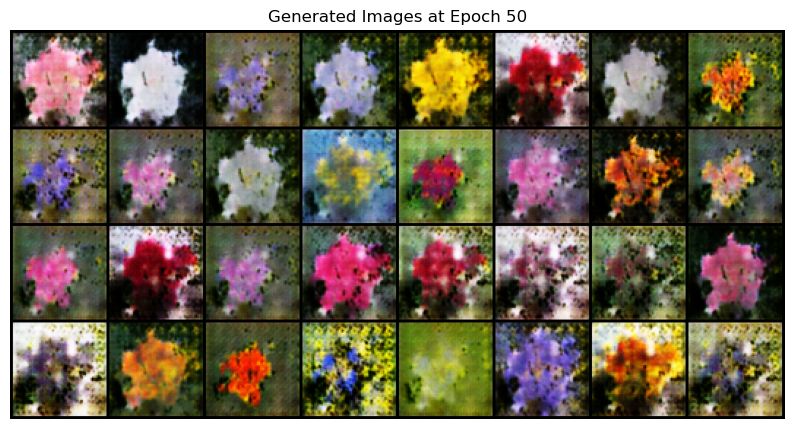

Epoch [51/100] D Loss: 0.4260 G Loss: 4.9050
Epoch [52/100] D Loss: 0.4085 G Loss: 4.9936
Epoch [53/100] D Loss: 0.3469 G Loss: 5.4568
Epoch [54/100] D Loss: 0.3459 G Loss: 6.3270
Epoch [55/100] D Loss: 0.3553 G Loss: 5.2070
Epoch [56/100] D Loss: 0.4212 G Loss: 5.0827
Epoch [57/100] D Loss: 0.2959 G Loss: 5.6572
Epoch [58/100] D Loss: 0.3728 G Loss: 5.9196
Epoch [59/100] D Loss: 0.3718 G Loss: 5.1061
Epoch [60/100] D Loss: 0.3194 G Loss: 5.5873


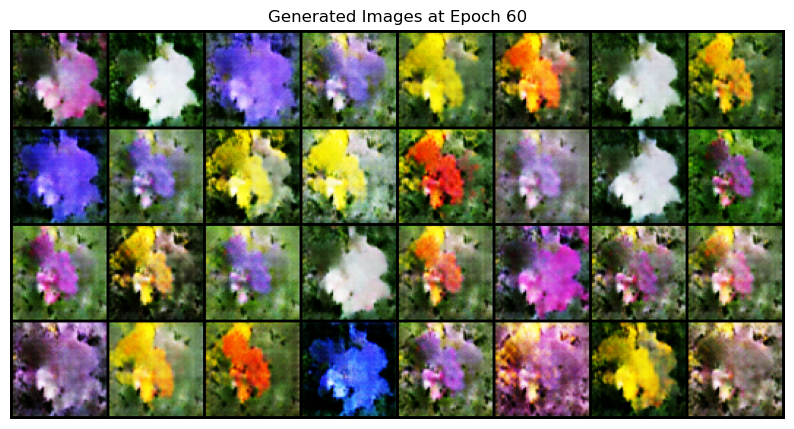

Epoch [61/100] D Loss: 0.3163 G Loss: 5.8384
Epoch [62/100] D Loss: 0.3792 G Loss: 5.4352
Epoch [63/100] D Loss: 0.3511 G Loss: 5.6105
Epoch [64/100] D Loss: 0.3829 G Loss: 5.0374
Epoch [65/100] D Loss: 0.2892 G Loss: 5.3975
Epoch [66/100] D Loss: 0.2080 G Loss: 6.0299
Epoch [67/100] D Loss: 0.3201 G Loss: 6.5147
Epoch [68/100] D Loss: 0.3366 G Loss: 6.0831
Epoch [69/100] D Loss: 0.2819 G Loss: 5.5536
Epoch [70/100] D Loss: 0.2998 G Loss: 5.5430


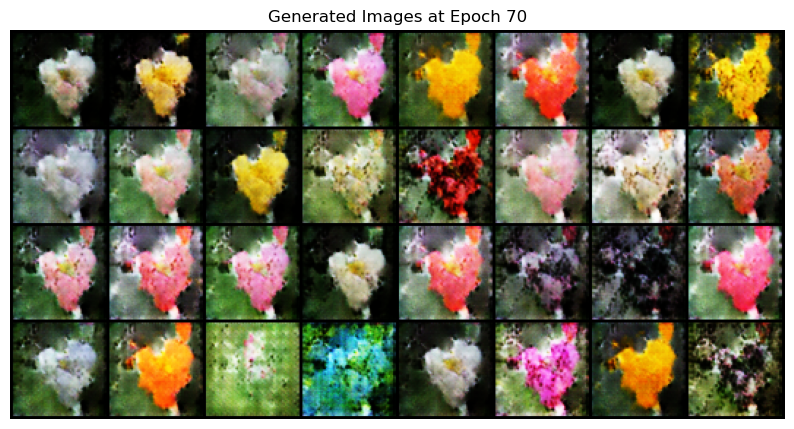

Epoch [71/100] D Loss: 0.2924 G Loss: 5.9411
Epoch [72/100] D Loss: 0.2897 G Loss: 5.5858
Epoch [73/100] D Loss: 0.3252 G Loss: 5.4854
Epoch [74/100] D Loss: 0.3608 G Loss: 5.4802
Epoch [75/100] D Loss: 0.3895 G Loss: 5.9044
Epoch [76/100] D Loss: 0.3217 G Loss: 5.8921
Epoch [77/100] D Loss: 0.3227 G Loss: 4.9264
Epoch [78/100] D Loss: 0.2837 G Loss: 5.1227
Epoch [79/100] D Loss: 0.3059 G Loss: 5.9687
Epoch [80/100] D Loss: 0.2688 G Loss: 5.7861


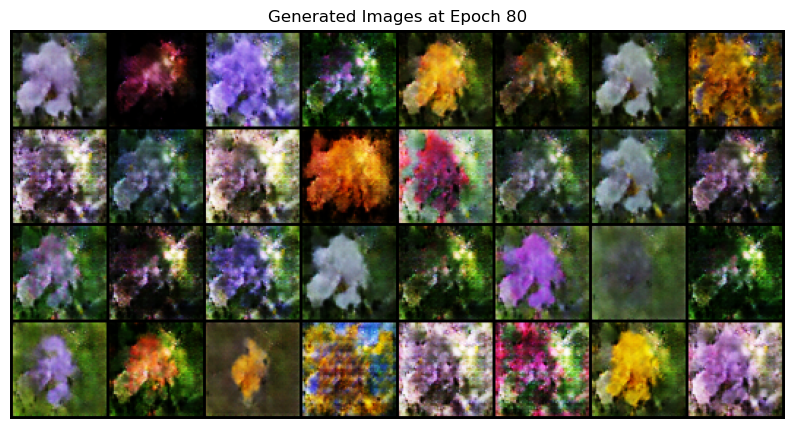

Epoch [81/100] D Loss: 0.3007 G Loss: 5.3254
Epoch [82/100] D Loss: 0.2977 G Loss: 5.4162
Epoch [83/100] D Loss: 0.3156 G Loss: 5.7234
Epoch [84/100] D Loss: 0.2853 G Loss: 5.7506
Epoch [85/100] D Loss: 0.3131 G Loss: 6.1988
Epoch [86/100] D Loss: 0.2634 G Loss: 6.5482
Epoch [87/100] D Loss: 0.3142 G Loss: 5.6256
Epoch [88/100] D Loss: 0.2795 G Loss: 5.7154
Epoch [89/100] D Loss: 0.2459 G Loss: 5.2029
Epoch [90/100] D Loss: 0.2879 G Loss: 5.2250


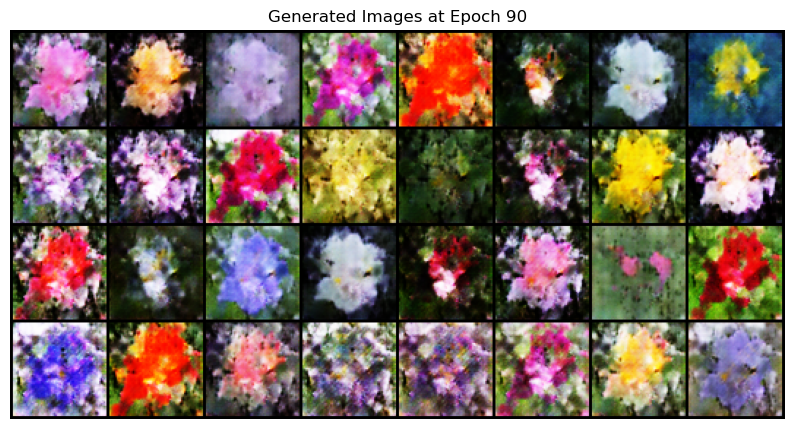

Epoch [91/100] D Loss: 0.2581 G Loss: 5.6173
Epoch [92/100] D Loss: 0.2491 G Loss: 5.6542
Epoch [93/100] D Loss: 0.3520 G Loss: 6.2677
Epoch [94/100] D Loss: 0.2614 G Loss: 5.8158
Epoch [95/100] D Loss: 0.3232 G Loss: 5.8214
Epoch [96/100] D Loss: 0.3109 G Loss: 5.7170
Epoch [97/100] D Loss: 0.3003 G Loss: 5.8125
Epoch [98/100] D Loss: 0.2974 G Loss: 5.9761
Epoch [99/100] D Loss: 0.2994 G Loss: 5.5551
Epoch [100/100] D Loss: 0.2680 G Loss: 5.8161


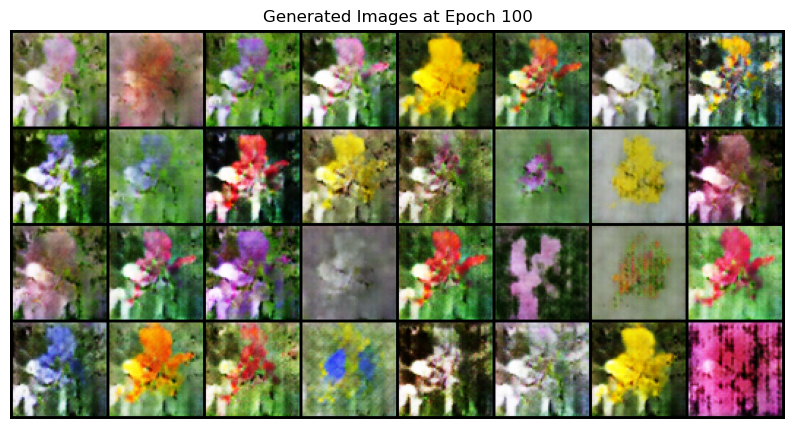

In [9]:
num_epochs = 100 

print("Starting Training...")

for epoch in range(num_epochs):
    G.train()
    D.train()

    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size_curr = imgs.size(0)

        real = torch.ones(batch_size_curr, device=device)
        fake = torch.zeros(batch_size_curr, device=device)

        batch_text_emb = text_embeddings[labels].to(device)

        optimizerD.zero_grad()
        output_real = D(imgs, batch_text_emb)
        loss_real = criterion(output_real, real)

        noise = torch.randn(batch_size_curr, noise_dim, device=device)
        fake_images = G(noise, batch_text_emb)
        output_fake = D(fake_images.detach(), batch_text_emb)
        loss_fake = criterion(output_fake, fake)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()
        
        optimizerG.zero_grad()
        output_fake_for_g = D(fake_images, batch_text_emb)
        loss_G = criterion(output_fake_for_g, real)
        loss_G.backward()
        optimizerG.step()

        epoch_d_loss += loss_D.item()
        epoch_g_loss += loss_G.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {epoch_d_loss/len(dataloader):.4f} G Loss: {epoch_g_loss/len(dataloader):.4f}")

    if (epoch + 1) % 10 == 0:
        G.eval()
        with torch.no_grad():
            fake_images = G(fixed_noise, fixed_text).cpu()
            grid = make_grid(fake_images, nrow=8, normalize=True)
            plt.figure(figsize=(10,10))
            plt.axis("off")
            plt.title(f"Generated Images at Epoch {epoch+1}")
            plt.imshow(np.transpose(grid, (1,2,0)))
            plt.show()

10. Generating and displaying final flower images using the trained Generator.

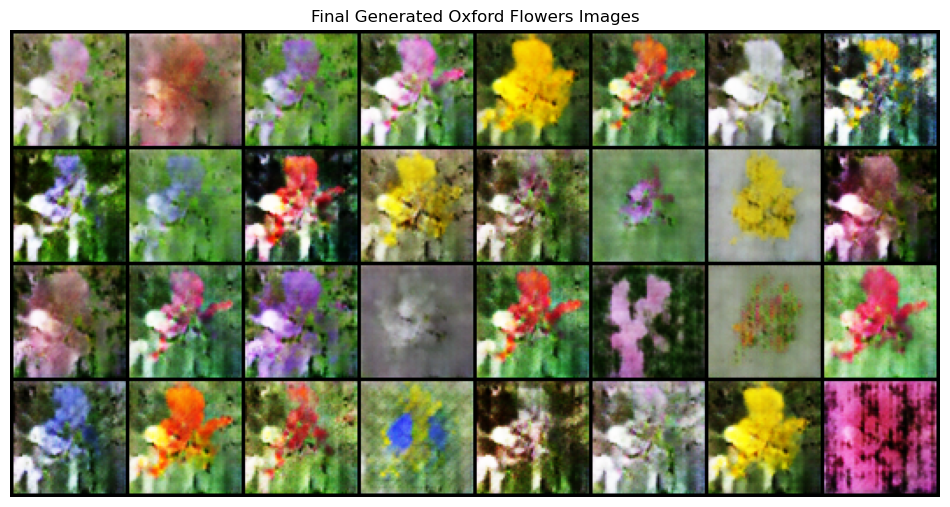

In [10]:
G.eval()
with torch.no_grad():
    noise = torch.randn(batch_size, noise_dim, device=device)
    text_emb = text_embeddings[:batch_size].to(device)
    generated_images = G(noise, text_emb).cpu()

    grid = make_grid(generated_images, nrow=8, normalize=True)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title("Final Generated Oxford Flowers Images")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()